## Downloading the data

In [3]:
!wget "http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz"

'wget' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


## Unzip the tar file

In [4]:
!tar -xvf 'speech_commands_v0.01.tar.gz' -C data/

tar: Error opening archive: Failed to open ''speech_commands_v0.01.tar.gz''


## Import the packages

In [5]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
warnings.filterwarnings("ignore")

## Data Exploration and Visualization

[ 0.00042725 -0.00021362 -0.00042725 ...  0.00057983  0.00061035
  0.00082397]
16000
16000


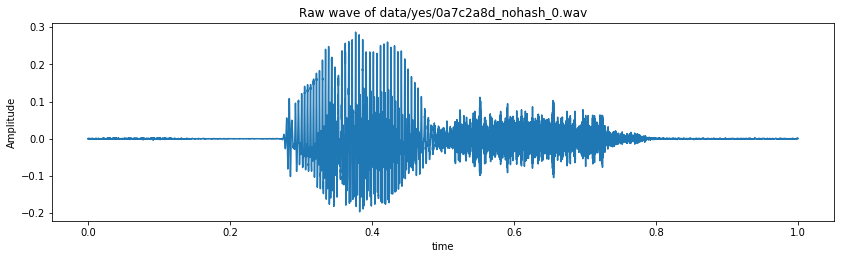

In [7]:
train_audio_path = 'data/'
samples, sample_rate = librosa.load(train_audio_path+'/yes/0a7c2a8d_nohash_0.wav', sr= 16000)
print(samples)
print(len(samples))
print(sample_rate)
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + 'data/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

### Sampling rate

In [8]:
ipd.Audio(samples, rate = sample_rate)
print(sample_rate)

16000


### Resampling

In [9]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate = 8000)

### Number of recording of each voices

In [14]:
labels = os.listdir(train_audio_path)
labels

['nine',
 'house',
 'five',
 'one',
 'tree',
 'sheila',
 'two',
 'four',
 'three',
 'six',
 'eight',
 'down',
 '.ipynb_checkpoints',
 'cat',
 'zero',
 'bird',
 'go',
 'marvin',
 'up',
 'wow',
 'seven',
 'happy',
 'on',
 'dog',
 'no',
 '_background_noise_',
 'left',
 'stop',
 'right',
 'yes',
 'off',
 'bed']

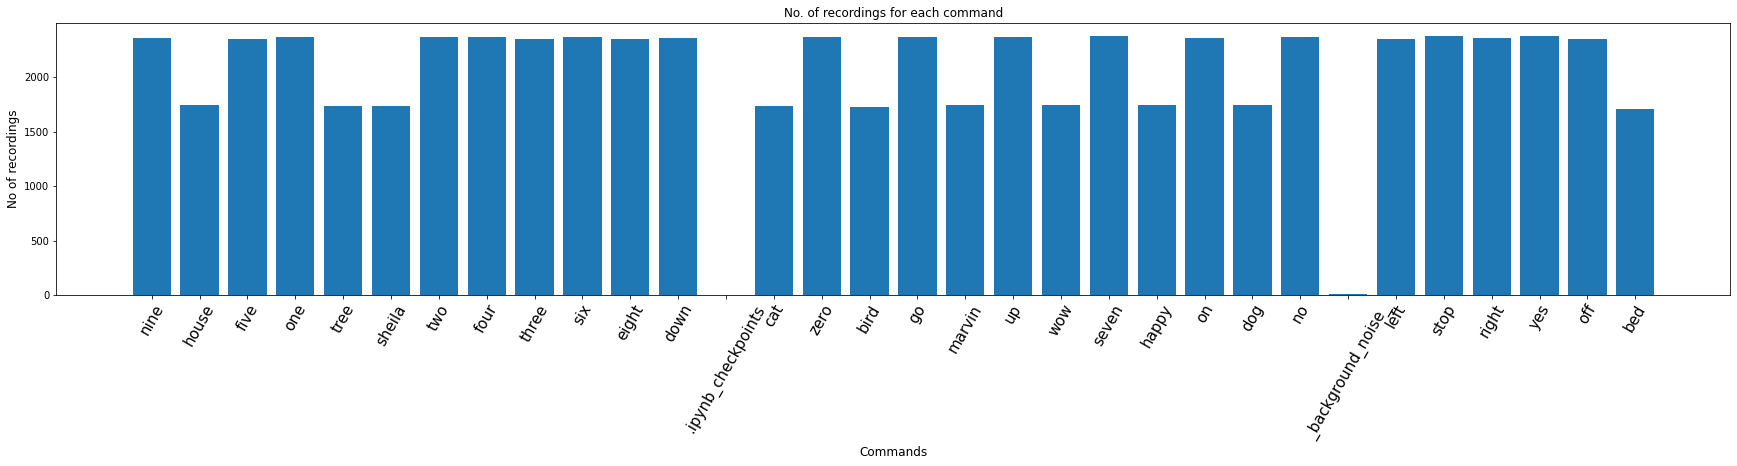

In [15]:
# find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
  waves = [f for f in os.listdir(train_audio_path + label) if f.endswith('.wav')]
  no_of_recordings.append(len(waves))

#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

labels = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

## Duration of recordings

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <a list of 10 Patch objects>)

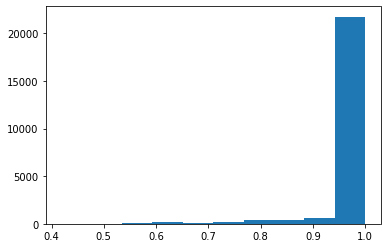

In [16]:
duration_of_recordings = []

for label in labels:
  waves = [f for f in os.listdir(train_audio_path + '/' + label) if f.endswith('.wav')]
  for wav in waves:
    sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
    duration_of_recordings.append(float(len(samples)/sample_rate))

plt.hist(np.array(duration_of_recordings))

### Preprocessing the audio waves

In [17]:
train_audio_path = 'data'

all_wave = []
all_label = []

for label in labels:
  print(label)
  waves = [f for f in os.listdir(train_audio_path + '/' + label) if f.endswith('.wav')]
  for wav in waves:
    samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
    samples = librosa.resample(samples, sample_rate, 8000)
    if (len(samples) == 8000):
      all_wave.append(samples)
      all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(all_label)
classes = list(le.classes_)

In [19]:
from keras.utils import np_utils
y = np_utils.to_categorical(y, num_classes= len(labels))
all_waves = np.array(all_wave).reshape(-1, 8000,1)

### Split into train and validation set

In [20]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave), np.array(y), stratify = y, test_size = 0.2, random_state = 7)
print(y_val)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Model Architecture for this problem

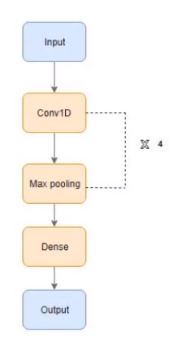

### Model building

In [21]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

# First Conv1D layer
conv = Conv1D(8, 13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)


# Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

# Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

# Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

# Flatten layer
conv = Flatten()(conv)

# Dense Layer 1
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

# Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)          

In [22]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [23]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10, min_delta = 0.0001)
mc = ModelCheckpoint('best_model.hdf5', monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

In [24]:
history = model.fit(x_tr, y_tr, epochs = 100, callbacks = [es, mc], batch_size= 32, validation_data= (x_val, y_val))

Epoch 1/100
533/533 [==============================] - 5s 9ms/step - loss: 2.1385 - accuracy: 0.1922 - val_loss: 2.0669 - val_accuracy: 0.2198
Epoch 2/100
533/533 [==============================] - 4s 8ms/step - loss: 1.7601 - accuracy: 0.3354 - val_loss: 1.5235 - val_accuracy: 0.4328
Epoch 3/100
533/533 [==============================] - 4s 8ms/step - loss: 1.4245 - accuracy: 0.4535 - val_loss: 1.5313 - val_accuracy: 0.4485
Epoch 4/100
533/533 [==============================] - 4s 8ms/step - loss: 1.2161 - accuracy: 0.5467 - val_loss: 1.0731 - val_accuracy: 0.6373
Epoch 5/100
533/533 [==============================] - 4s 8ms/step - loss: 1.0565 - accuracy: 0.6226 - val_loss: 0.8781 - val_accuracy: 0.7030
Epoch 6/100
533/533 [==============================] - 4s 8ms/step - loss: 0.9550 - accuracy: 0.6557 - val_loss: 0.8032 - val_accuracy: 0.7363
Epoch 7/100
533/533 [==============================] - 4s 8ms/step - loss: 0.8788 - accuracy: 0.6868 - val_loss: 0.8113 - val_accuracy: 0.7340

In [25]:
model.save("best_model.hdf5")

### Diagnostic plot

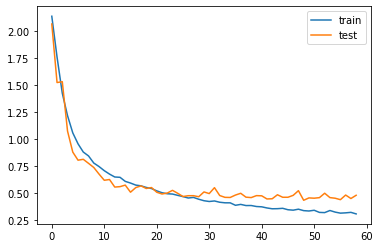

In [26]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.savefig("plot.jpg")
pyplot.show()

### Loading the best model

In [28]:
from keras.models import load_model
model = load_model('best_model.hdf5')

def predict(audio):
  prob = model.predict(audio.reshape(1,8000,1))
  index = np.argmax(prob[0])
  return classes[index]

In [29]:
import random

index = random.randint(0, len(x_val)-1)
samples = x_val[index].ravel()
print('Audio: ', classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate = 8000)
print('Text: ', predict(samples))

Audio:  no
Text:  no


### Prediction Time - Make prediction on the validation data:

In [2]:
!pip install sounddevice

In [7]:
################################################################################
# INSTALL CONDA ON GOOGLE COLAB
################################################################################
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-10-05 13:46:21--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   200MB/s    in 0.4s    

2020-10-05 13:46:22 (200 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

In [8]:
! conda install pyaudio

Solving environment: \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - pyaudio


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.7.22  |                0         125 KB
    certifi-2020.6.20          |           py37_0         156 KB
    conda-4.8.5                |           py37_0         2.8 MB
    openssl-1.1.1h             |       h7b6447c_0         2.5 MB
    portaudio-19.6.0           |       h7b6447c_4         114 KB
    pyaudio-0.2.11             |   py37h7b6447c_2         206 KB
    ------------------------------------------------------------
                                           Total:         6.0 MB

The following NEW packages will be INSTALLED:

  portaudio          pkgs/main/linux-64::portaudio-19.6.0-h7b6447c_4
  pyaudio            pkgs/main/linux-64::pyaudio-0.2.11-py37h7b6447c_2

The followi

In [10]:
!conda install -c anaconda portaudio

Solving environment: / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - portaudio


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.7.22  |                0         132 KB  anaconda
    certifi-2020.6.20          |           py37_0         159 KB  anaconda
    conda-4.8.5                |           py37_0         3.1 MB  anaconda
    openssl-1.1.1h             |       h7b6447c_0         3.8 MB  anaconda
    portaudio-19.6.0           |       h7b6447c_4         132 KB  anaconda
    ------------------------------------------------------------
                                           Total:         7.3 MB

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates                                 pkgs/main --> anaconda
  certifi                                         pkgs/main --> an

In [2]:
import sounddevice as sd
import soundfile as sf

In [ ]:
samplerate = 16000
duration = 1 #seconds
filename = 'yes.wav'
print("start")

mydata = sd.rec(int(samplerate * duration), samplerate = samplerate, channels = 1, blocking = True)
print("end")

sd.wait()
sf.write(filename, mydata, samplerate)

In [ ]:
import os

os.listdir('../input/voice-commands/voice_v2')
filepatch = '../input/voice-commands/voice_v2'

# reading the voice commands
samples, sample_rate = librosa.load(filepatch + '/' + 'stop.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate = 8000)

predict(samples)

In [6]:
!pip install --upgrade setuptools
!pip install prosodic

Requirement already up-to-date: setuptools in d:\users\elain\anaconda3\lib\site-packages (50.3.0)
  Using cached https://files.pythonhosted.org/packages/c2/e7/2b122e4108f07a117a1d47bc1c92e233a97132286cd1cdbd9c357e162130/prosodic-1.3.8.tar.gz
    Complete output from command python setup.py egg_info:
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "C:\Users\elain\AppData\Local\Temp\pip-install-anugp60q\prosodic\setup.py", line 39, in <module>
        long_description = fh.read()
      File "D:\Users\elain\Anaconda3\lib\encodings\cp1252.py", line 23, in decode
        return codecs.charmap_decode(input,self.errors,decoding_table)[0]
    UnicodeDecodeError: 'charmap' codec can't decode byte 0x90 in position 10977: character maps to <undefined>
    
    ----------------------------------------


Command "python setup.py egg_info" failed with error code 1 in C:\Users\elain\AppData\Local\Temp\pip-install-anugp60q\prosodic\


In [3]:
# Prosodic Analysis
import prosodic as pc

#create a text object
text = p.Text(string_or_filename)

#parse metrically
text.parse()

# save stats
text.save_stats()

#iterate over features
for line in tex.lines():
    best_parse = line.bestParse() #most plausible parse
    all_parses = line.allParces() #all plausible parse
    first_word = line.words()[0]
    last_syllable = line.syllables()[-1]
    last_syllable_rime = line.rimes()[-1]
    last_syllable_rime_phonemes = last_syllable_rime.phonemes()

ModuleNotFoundError: No module named 'prosodic'